### Import libraries and load files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('ggplot')
# toxprint_.pkl file sourced from GenRA_LD50_Example
tox= pd.read_pickle('../Inputs/toxprint_.pkl')
tox = tox[['Y_true','Y_pred','tox_list']]
tox.head()
#https://github.com/patlewig/acute_oral/blob/master/notebooks/01_model_datasets.ipynb

,Y_true,Y_pred,tox_list
DTXSID5020281,-0.465339,-0.279420,"[tox_184, tox_195, tox_196, tox_301, tox_585]"
DTXSID8020961,-0.734786,-0.863139,"[tox_97, tox_100, tox_101, tox_195, tox_196, t..."
DTXSID0021834,-0.087091,-0.209883,"[tox_122, tox_123, tox_128, tox_195, tox_196, ..."
DTXSID2044347,-1.058925,-1.073014,"[tox_68, tox_70, tox_73, tox_85, tox_86, tox_1..."
DTXSID4025745,-1.022972,-0.931206,"[tox_152, tox_153, tox_154, tox_155, tox_162, ..."


### Calculate Error and plot Error distribution

Text(0.5, 1.0, 'ToxPrints')

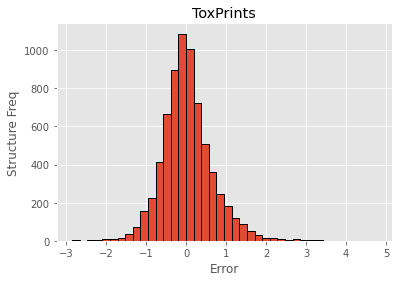

In [2]:
tox['Error'] = tox['Y_true']- tox['Y_pred']
tox['Abs_Error'] = np.abs(tox['Error'])
tox.name = 'full'

X = tox['Error']
n,bins,patches = plt.hist(X,bins=40,linewidth=1,edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Structure Freq')
plt.title('ToxPrints')


In [3]:
print(tox.shape)
tox.mean()

(6972, 5)


Y_true      -0.496437
Y_pred      -0.525617
Error        0.029180
Abs_Error    0.468173
dtype: float64

## Make sub-dataframe of best/worst prediction results

#### Worst 5%

In [4]:
from math import floor
frac = floor(len(tox)*.05)
tox_worst = tox.sort_values(by=['Abs_Error'],ascending=False).head(frac)
tox_worst.name = 'worst_5_perc'
print(tox_worst.shape)
tox_worst.mean()

(348, 5)


Y_true       0.651425
Y_pred      -0.227720
Error        0.879145
Abs_Error    1.757085
dtype: float64

#### Best 5%

In [5]:
tox_best = tox.sort_values(by=['Abs_Error']).head(frac)  #
tox_best.name = 'best_5_perc'
print(tox_best.shape)
tox_best.mean()

(348, 5)


Y_true      -0.616690
Y_pred      -0.617723
Error        0.001032
Abs_Error    0.014765
dtype: float64

## Find the frequency of fragments in each dataset
    - Interested to know the differences in distribution of individual fragments in structure set
    - Which fragments show up more frequently for better/worse predictions?
    

In [6]:
from collections import Counter
def frag_freq(df,col_name,frac=True):
    fragments = []
    for row in df[col_name]:  
        for fragment in row:
            fragments.append(fragment)

    frequency = Counter(fragments)

    for item, count in frequency.items():
        if frac == True:
            frequency[item] = np.round(frequency[item]/df.shape[0],4)
    
    df = pd.DataFrame.from_dict(frequency, orient='index', columns=[df.name])
    
    return df


In [7]:
# Find fragment freq using our previous dfs
best = frag_freq(tox_best,'tox_list')
full = frag_freq(tox,'tox_list')
worst = frag_freq(tox_worst,'tox_list')


In [8]:
# Merge all together to a single df
compare = pd.merge(full,worst,how='outer',left_index=True,right_index=True)
compare = pd.merge(compare,best,how='outer',left_index=True,right_index=True)
compare = compare.fillna(0)
compare.sort_values(by=['full'],ascending=False).head(10)

# compare = compare[compare['full']>0.1] optional filter, presence of fragment

# Can see Toxprint_585 has higher presence in "best" predictions, lower presence in "worst" predictions

,full,worst_5_perc,best_5_perc
tox_585,0.5577,0.4511,0.5948
tox_70,0.4872,0.4684,0.4914
tox_436,0.3805,0.3103,0.4310
tox_301,0.3373,0.3362,0.3678
tox_476,0.3012,0.2443,0.3305
tox_437,0.2400,0.1523,0.2874
tox_678,0.2174,0.2356,0.2500
tox_475,0.2131,0.1897,0.2471
tox_214,0.2111,0.2385,0.2069
tox_36,0.2104,0.2385,0.2069


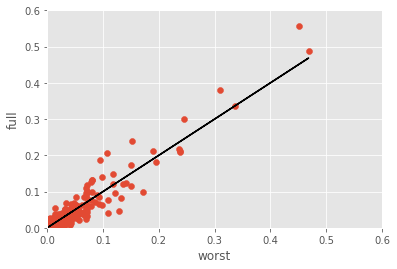

In [9]:
X = compare['worst_5_perc']
y = compare['full']
plt.ylabel('full')
plt.xlabel('worst')
plt.xlim([0,0.6])
plt.ylim([0,0.6])

plt.scatter(X,y)
plt.plot(X,X,color='black')

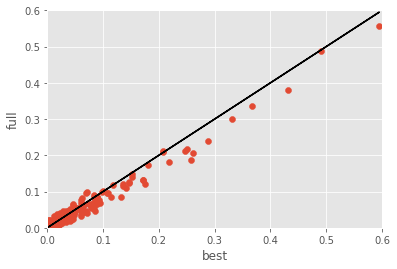

In [10]:
X = compare['best_5_perc']
y = compare['full']
plt.scatter(X,y)
plt.xlabel('best')
plt.ylabel('full')
plt.xlim([0,0.6])
plt.ylim([0,0.6])
plt.plot(X,X,color='black')

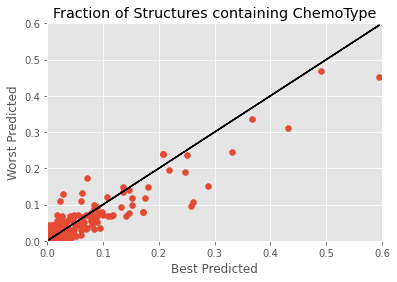

In [11]:
X = compare['best_5_perc']
y = compare['worst_5_perc']
plt.scatter(X,y)
plt.xlabel('Best Predicted')
plt.ylabel('Worst Predicted')
plt.xlim([0,0.6])
plt.ylim([0,0.6])
plt.title('Fraction of Structures containing ChemoType')
plt.plot(X,X,color='black')

In [12]:
# ignore for now
#compare['Odds Ratio'] = (compare['worst_5_perc']+(1-compare['best_5_perc'])) /(compare['best_5_perc']+(1-compare['worst_5_perc']))
#compare.sort_values(by=['Odds Ratio'],ascending=False)

DataSet 1: Worst 5% Predicted Structures, 348 structures

DataSet 2: Best 5% Predicted Structures, 348 structures

- Features per structure: 
        -Presence of Fragment (548, boolean)
        -Actual Toxicity (1, float)
        -Predicted Toxicity (1, float)
        -Prediction Error (1, float)
        
- Features of dataset
        -Fraction of presence of fragment (548, float)
        -Mean Actual Toxicity (1, float)
        -Mean Predicted Toxicity (1, float)
        -Mean Prediction Error (1, float)
        


| Feature      | Best_      | Worst_    |
| ------------ | -----------|---------- |
|  Present     |    a       |     b   |
| Not Present  |   c        |    d      |

Odds Ratio = (a+d)/(c+b)

In [13]:
import scipy.stats as stats
a = [[1,2],[3,4]]
stats.fisher_exact(a,alternative='greater')


(0.6666666666666666, 0.8333333333333334)

In [14]:
bestcount = frag_freq(tox_best,'tox_list',False)
worstcount = frag_freq(tox_worst,'tox_list',False)
compare_counts = pd.merge(bestcount,worstcount,how='outer',left_index=True,right_index=True).fillna(0)
# best_5_perc column: N structures in dataset 1 with Fragment 
# worst_5_perc column: N structures in dataset 2 with fragment

In [15]:
compare_counts['c'] = len(tox_best)-compare_counts['best_5_perc']  #N structures without frag in dataset 1
compare_counts['d'] = len(tox_worst)-compare_counts['worst_5_perc'] # N structures without frag in dataset 2

compare_counts['list'] = compare_counts[['best_5_perc','worst_5_perc','c','d']].values.tolist()
compare_counts['list'] = compare_counts['list'].apply(lambda x: np.array(x).reshape((2,2)))

In [16]:
compare_counts['stats'] = compare_counts['list'].apply(lambda x: stats.fisher_exact(x,alternative='greater') )

In [17]:
compare_counts['Odds Ratio'] =   compare_counts["stats"].apply(lambda x : x[0])
compare_counts['P-value'] =   compare_counts["stats"].apply(lambda x : x[1])
compare_counts = compare_counts.drop(columns=['stats'])

In [18]:
compare_counts.sort_values(by=['P-value'])

,best_5_perc,worst_5_perc,c,d,list,Odds Ratio,P-value
tox_93,90.0,33.0,258.0,315.0,"[[90.0, 33.0], [258.0, 315.0]]",3.329810,8.076905e-09
tox_438,91.0,37.0,257.0,311.0,"[[91.0, 37.0], [257.0, 311.0]]",2.976233,7.666207e-08
tox_437,100.0,53.0,248.0,295.0,"[[100.0, 53.0], [248.0, 295.0]]",2.244370,1.142700e-05
tox_585,207.0,157.0,141.0,191.0,"[[207.0, 157.0], [141.0, 191.0]]",1.786014,9.788580e-05
tox_106,60.0,28.0,288.0,320.0,"[[60.0, 28.0], [288.0, 320.0]]",2.380952,1.808531e-04
...,...,...,...,...,...,...,...
tox_26,0.0,1.0,348.0,347.0,"[[0.0, 1.0], [348.0, 347.0]]",0.000000,1.000000e+00
tox_628,0.0,2.0,348.0,346.0,"[[0.0, 2.0], [348.0, 346.0]]",0.000000,1.000000e+00
tox_452,0.0,1.0,348.0,347.0,"[[0.0, 1.0], [348.0, 347.0]]",0.000000,1.000000e+00
tox_139,0.0,3.0,348.0,345.0,"[[0.0, 3.0], [348.0, 345.0]]",0.000000,1.000000e+00


In [19]:
compare_counts[compare_counts['P-value']<0.05].shape

(42, 7)